In [85]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [86]:
aa_sim = pd.read_csv('/home/jupyter-l.fedoseeva-12/Mat_stats/Lesson_10/hw_aa.csv',sep=";")

In [87]:
aa_sim.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


Делаем A/A-тест и видим, что FTR > альфа (0.948 > 0.05)

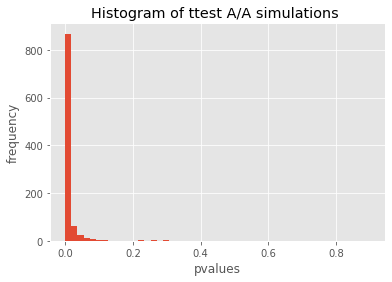

0.948

In [88]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = aa_sim[aa_sim.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    s2 = aa_sim[aa_sim.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Сгруппируем по варианту и версии МП и посчитаем средние значения. Судя по этим данные, выбивается версия v2.8.0

In [89]:
aa_sim.groupby(['experimentVariant', 'version'], as_index=False)\
    .agg({'purchase': 'mean'})

,experimentVariant,version,purchase
0,0,v2.8.0,0.000993
1,0,v2.9.0,0.074658
2,0,v3.7.4.0,0.059943
3,0,v3.8.0.0,0.057604
4,1,v2.8.0,0.045606
5,1,v2.9.0,0.071304
6,1,v3.7.4.0,0.063018
7,1,v3.8.0.0,0.062848


Version   v2.8.0    pvalue=0.0

In [90]:
stats.ttest_ind(aa_sim[(aa_sim.experimentVariant == 1) & (aa_sim.version == 'v2.8.0')]['purchase'], 
                aa_sim[(aa_sim.experimentVariant == 0) & (aa_sim.version == 'v2.8.0')]['purchase'])

Ttest_indResult(statistic=42.963540840360324, pvalue=0.0)

Version  v2.9.0    p-value = 0.318

In [91]:
stats.ttest_ind(aa_sim[(aa_sim.experimentVariant == 1) & (aa_sim.version == 'v2.9.0')]['purchase'], 
                aa_sim[(aa_sim.experimentVariant == 0) & (aa_sim.version == 'v2.9.0')]['purchase'])

Ttest_indResult(statistic=-0.9979597634962479, pvalue=0.31830895167207446)

Version v3.7.4.0   p-value=0.5569

In [92]:
stats.ttest_ind(aa_sim[(aa_sim.experimentVariant == 1) & (aa_sim.version == 'v3.7.4.0')]['purchase'], 
                aa_sim[(aa_sim.experimentVariant == 0) & (aa_sim.version == 'v3.7.4.0')]['purchase'])

Ttest_indResult(statistic=0.5874925850487471, pvalue=0.5568886771079735)

Version  v3.8.0.0    p-value=0.2318

In [93]:
stats.ttest_ind(aa_sim[(aa_sim.experimentVariant == 1) & (aa_sim.version == 'v3.8.0.0')]['purchase'], 
                aa_sim[(aa_sim.experimentVariant == 0) & (aa_sim.version == 'v3.8.0.0')]['purchase'])

Ttest_indResult(statistic=1.1956188950206779, pvalue=0.23186933664059722)

Попробуем исключить версию v2.8.0 т.к. у нее меньше 0.05 (pvalue=0.0)

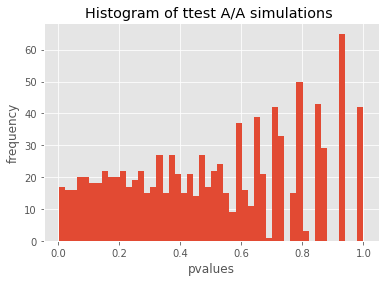

0.039

In [97]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = aa_sim[(aa_sim.experimentVariant == 1) & (aa_sim.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    s2 = aa_sim[(aa_sim.experimentVariant == 1) & (aa_sim.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Выводы:

Проверя A/A тест на начальных данных, получили, что FTR > альфа (0.948 > 0.05), слдовательно надо искать поломки.
С помощью t-теста посчитали p-value для различных версий мобильного приложения.
Для версии v2.8.0 pvalue=0.0, поэтому в А/А тесте будем пробовать убрать эту версию моб.приложения.
Убрав эту версию, получили FPR = 0.039 и он меньше альфа, которая равна 0.05, следовательно, мы нашли поломку.